# Introduction to Kernels

In this guide we provide an introduction to kernels, and the role they play in Gaussian process models.

In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Float,
    install_import_hook,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
import pandas as pd
from sklearn.preprocessing import StandardScaler

import gpjax as gpx
from gpjax.parameters import Parameter
from gpjax.typing import Array

config.update("jax_enable_x64", True)

key = jr.key(42)

# set the default style for plotting
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

Using Gaussian Processes (GPs) to model functions can offer several advantages over
alternative methods, such as deep neural networks. One key advantage is their rich
quantification of uncertainty; not only do they provide *point estimates* for the
values taken by a function throughout its domain, but they provide a full predictive
posterior *distribution* over the range of values the function may take. This rich
quantification of uncertainty is useful in many applications, such as Bayesian
optimisation, which relies on being able to make *uncertainty-aware* decisions.

However, another advantage of GPs is the ability for one to place *priors* on the
functions being modelled. For instance, one may know that the underlying function
being modelled observes certain characteristics, such as being *periodic* or having a
certain level of *smoothness*. The *kernel*, or *covariance function*, is the primary
means through which one is able to encode such prior knowledge about the function
being modelled. This enables one to equip the GP with inductive biases which enable it
to learn from data more efficiently, whilst generalising to unseen data more
effectively.

In this notebook we'll develop some intuition for what kinds of priors are encoded
through the use of different kernels, and how this can be useful when modelling
different types of functions.

## What is a Kernel?

Intuitively, for a function $f$, the kernel defines the notion of *similarity* between
the value of the function at two points, $f(\mathbf{x})$ and $f(\mathbf{x}')$, and
will be denoted as $k(\mathbf{x}, \mathbf{x}')$:

$$
\begin{aligned}
  k(\mathbf{x}, \mathbf{x}') &= \text{Cov}[f(\mathbf{x}), f(\mathbf{x}')] \\
  &= \mathbb{E}[(f(\mathbf{x}) - \mathbb{E}[f(\mathbf{x})])(f(\mathbf{x}') - \mathbb{E}[f(\mathbf{x}')])]
\end{aligned}
$$

One would expect that, given a previously unobserved test point $\mathbf{x}^*$, the
training points which are *closest* to this unobserved point will be most similar to
it. As such, the kernel is used to define this notion of similarity within the GP
framework. It is up to the user to select a kernel function which is appropriate for
the function being modelled. In this notebook we are going to give some examples of
commonly used kernels, and try to develop an understanding of when one may wish to use
one kernel over another. However, before we do this, it is worth discussing the
necessary conditions for a function to be a valid kernel/covariance function. This
requires a little bit of maths, so for those of you who just wish to obtain an
intuitive understanding, feel free to skip to the section introducing the Matérn
 family of kernels.

### What are the necessary conditions for a function to be a valid kernel?

Whilst intuitively the kernel function is used to define the notion of similarity within
the GP framework, it is important to note that there are two *necessary conditions*
that a kernel function must satisfy in order to be a valid covariance function. For
clarity, we will refer to *any* function mapping two inputs to a scalar output as a
*kernel function*, and we will refer to a *valid* kernel function satisfying the two
necessary conditions as a *covariance function*. However, it is worth noting that the
GP community often uses the terms *kernel function* and *covariance function*
interchangeably.

The first necessary condition is that the covariance function must be *symmetric*, i.e.
$k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}', \mathbf{x})$. This is because the
covariance between two random variables $X$ and $X'$ is symmetric; if one looks at the
definition of covariance given above, it is clear that it is invariant to swapping the
order of the inputs $\mathbf{x}$ and $\mathbf{x}'$.

The second necessary condition is that the covariance function must be *positive
semi-definite* (PSD). In order to understand this condition, it is useful to first
introduce the concept of a *Gram matrix*. We'll use the same notation as the [GP introduction
notebook](https://docs.jaxgaussianprocesses.com/_examples/intro_to_gps/), and denote
$n$ input points as $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_n\}$. Given these
input points and a kernel function $k$ the *Gram matrix* stores the pairwise kernel
evaluations between all input points. Mathematically, this leads to the Gram matrix being defined as:

$$K(\mathbf{X}, \mathbf{X}) = \begin{bmatrix} k(\mathbf{x}_1, \mathbf{x}_1) & \cdots & k(\mathbf{x}_1, \mathbf{x}_n) \\ \vdots & \ddots & \vdots \\ k(\mathbf{x}_n, \mathbf{x}_1) & \cdots & k(\mathbf{x}_n, \mathbf{x}_n) \end{bmatrix}$$

such that $K(\mathbf{X}, \mathbf{X})_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$.

In order for $k$ to be a valid covariance function, the corresponding Gram matrix
must be *positive semi-definite*. In this case the Gram matrix is referred to as a
*covariance matrix*. A real $n \times n$ matrix $K$ is positive semi-definite if and
only if for all vectors $\mathbf{z} \in \mathbb{R}^n$:

$$\mathbf{z}^\top K \mathbf{z} \geq 0$$

Alternatively, a real $n \times n$ matrix $K$ is positive semi-definite if and only if
all of its eigenvalues are non-negative.

Therefore, the two necessary conditions for a function to be a valid covariance function
are that it must be *symmetric* and *positive semi-definite*. In this section we have
referred to *any* function from two inputs to a scalar output as a *kernel function*,
with its corresponding matrix of pairwise evaluations referred to as the *Gram matrix*,
and a function satisfying the two necessary conditions as a *covariance function*, with
its corresponding matrix of pairwise evaluations referred to as the *covariance matrix*.
This enabled us to easily define the necessary conditions for a function to be a valid
covariance function. However, as noted previously, the GP community often uses these
terms interchangeably, and so we will for the remainder of this notebook.


## Introducing a Common Family of Kernels - The Matérn Family

One of the most widely used families of kernels is the Matérn family ([Matérn, 1960](https://core.ac.uk/download/pdf/11698705.pdf)). These kernels take on the following form:

$$k_{\nu}(\mathbf{x}, \mathbf{x'}) = \sigma^2 \frac{2^{1 - \nu}}{\Gamma(\nu)}\left(\sqrt{2\nu} \frac{|\mathbf{x} - \mathbf{x'}|}{\kappa}\right)^{\nu} K_{\nu} \left(\sqrt{2\nu} \frac{|\mathbf{x} - \mathbf{x'}|}{\kappa}\right)$$

where $K_{\nu}$ is a modified Bessel function, $\nu$, $\kappa$ and $\sigma^2$ are
hyperparameters specifying the mean-square differentiability, lengthscale and
variability respectively, and $|\cdot|$ is used to denote the Euclidean norm. Note that
for those of you less interested in the mathematical underpinnings of kernels, it isn't
necessary to understand the exact functional form of the Matérn kernels to
gain an understanding of how they behave. The key takeaway is that they are
parameterised by several hyperparameters, and that these hyperparameters dictate the
behaviour of functions sampled from the corresponding GP. The plots below will provide
some more intuition for how these hyperparameters affect the behaviour of functions
sampled from the corresponding GP.


Some commonly used Matérn kernels use half-integer values of $\nu$, such as $\nu = 1/2$
or $\nu = 3/2$. The fraction is sometimes omitted when naming the kernel, so that $\nu =
1/2$ is referred to as the Matérn12 kernel, and $\nu = 3/2$ is referred to as the
Matérn32 kernel. When $\nu$ takes in a half-integer value, $\nu = k + 1/2$, the kernel
can be expressed as the product of a polynomial of order $k$ and an exponential:

$$k_{k + 1/2}(\mathbf{x}, \mathbf{x'}) = \sigma^2
\exp\left(-\frac{\sqrt{2\nu}|\mathbf{x} - \mathbf{x'}|}{\kappa}\right)
\frac{\Gamma(k+1)}{\Gamma(2k+1)} \times \sum_{i= 0}^k \frac{(k+i)!}{i!(k-i)!}
\left(\frac{(\sqrt{8\nu}|\mathbf{x} - \mathbf{x'}|)}{\kappa}\right)^{k-i}$$

In the limit of $\nu \to \infty$ this yields the *squared-exponential*, or *radial basis function (RBF)*, kernel, which is infinitely mean-square differentiable:

$$k_{\infty}(\mathbf{x}, \mathbf{x'}) = \sigma^2 \exp\left(-\frac{|\mathbf{x} - \mathbf{x'}|^2}{2\kappa^2}\right)$$

But what kind of functions does this kernel encode prior knowledge about? Let's take a look at some samples from GP priors defined used Matérn kernels with different values of $\nu$:

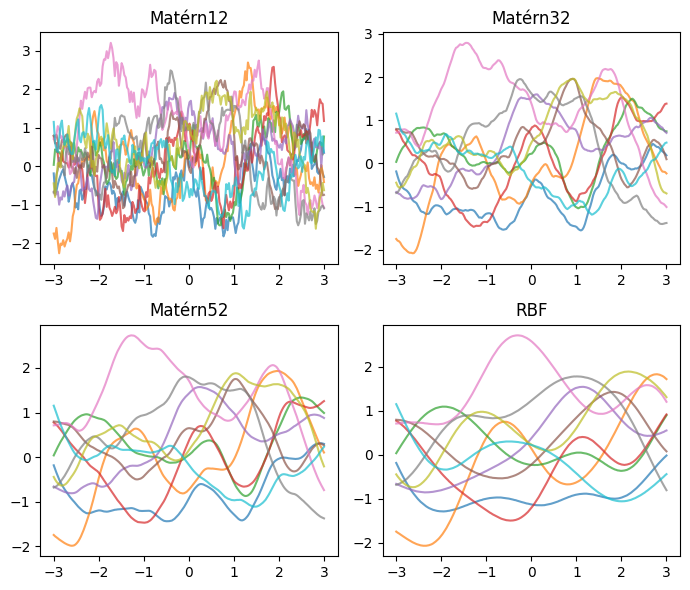

In [2]:
kernels = [
    gpx.kernels.Matern12(),
    gpx.kernels.Matern32(),
    gpx.kernels.Matern52(),
    gpx.kernels.RBF(),
]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6), tight_layout=True)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)

meanf = gpx.mean_functions.Zero()

for k, ax in zip(kernels, axes.ravel(), strict=False):
    prior = gpx.gps.Prior(mean_function=meanf, kernel=k)
    rv = prior(x)
    y = rv.sample(key=key, sample_shape=(10,))
    ax.plot(x, y.T, alpha=0.7)
    ax.set_title(k.name)

The plots above clearly show that the choice of $\nu$ has a large impact on the *smoothness* of the functions being modelled by the GP, with functions drawn from GPs defined with the Matérn kernel becoming increasingly smooth as $\nu \to \infty$. More formally, this notion of smoothness is captured through the mean-square differentiability of the function being modelled. Functions sampled from GPs using a Matérn kernel are $k$-times mean-square differentiable, if and only if $\nu > k$. For instance, functions sampled from a GP using a Matérn12 kernel are zero times mean-square differentiable, and functions sampled from a GP using the RBF kernel are infinitely mean-square differentiable.

As an important aside, a general property of the Matérn family of kernels is that they are examples of *stationary* kernels. This means that they only depend on the *displacement* of the two points being compared, $\mathbf{x} - \mathbf{x}'$, and not on their absolute values. This is a useful property to have, as it means that the kernel is invariant to translations in the input space. They also go beyond this, as they only depend on the Euclidean *distance* between the two points being compared, $|\mathbf{x} - \mathbf{x}'|$. Kernels which satisfy this property are known as *isotropic* kernels. This makes the function invariant to all rigid motions in the input space, such as rotations.

## Inferring Kernel Hyperparameters

Most kernels have several *hyperparameters*, which we denote $\mathbf{\theta}$, which encode different assumptions about the underlying function being modelled. For the Matérn family described above, $\mathbf{\theta} = \{\nu, \kappa, \sigma\}$. A fully Bayesian approach to dealing with hyperparameters would be to place a prior over them, and marginalise over the posterior derived from the data in order to perform predictions. However, this is often computationally very expensive, and so a common approach is to instead *optimise* the hyperparameters by maximising the log marginal likelihood of the data. Given training data $\mathbf{D} = (\mathbf{X}, \mathbf{y})$, assumed to contain some additive Gaussian noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$, the log marginal likelihood of the dataset is defined as:

$$ \begin{aligned}
\log(p(\mathbf{y} | \mathbf{X}, \boldsymbol{\theta})) &= \log\left(\int p(\mathbf{y} | \mathbf{f}, \mathbf{X}, \boldsymbol{\theta}) p(\mathbf{f} | \mathbf{X}, \boldsymbol{\theta}) d\mathbf{f}\right) \nonumber \\
&= - \frac{1}{2} \mathbf{y} ^ \top \left(K(\mathbf{X}, \mathbf{X}) + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y} - \frac{1}{2} \log |K(\mathbf{X}, \mathbf{X}) + \sigma^2 \mathbf{I}| - \frac{n}{2} \log 2 \pi
\end{aligned}$$

This expression can then be maximised with respect to the hyperparameters using a
gradient-based approach such as Adam or L-BFGS. Note that we may choose to fix some
hyperparameters, and in GPJax the parameter $\nu$ is set by the user, and not
inferred though optimisation. For more details on using the log marginal likelihood to
optimise kernel hyperparameters, see our [GP introduction notebook](https://docs.jaxgaussianprocesses.com/_examples/intro_to_gps/#gaussian-process-regression).

We'll demonstrate the advantages of being able to infer kernel parameters from the training data by fitting a GP to the widely used [Forrester function](https://www.sfu.ca/~ssurjano/forretal08.html):

$$f(x) = (6x - 2)^2 \sin(12x - 4)$$

In [3]:
# Forrester function
def forrester(x: Float[Array, "N"]) -> Float[Array, "N"]:  # noqa: F821
    return (6 * x - 2) ** 2 * jnp.sin(12 * x - 4)


n = 13

training_x = jr.uniform(key=key, minval=0, maxval=1, shape=(n,)).reshape(-1, 1)
training_y = forrester(training_x)
D = gpx.Dataset(X=training_x, y=training_y)

test_x = jnp.linspace(0, 1, 100).reshape(-1, 1)
test_y = forrester(test_x)

First we define our model, using the Matérn52 kernel, and construct our posterior *without* optimising the kernel hyperparameters:

In [4]:
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.Matern52(
    lengthscale=jnp.array(0.1)
)  # Initialise our kernel lengthscale to 0.1

prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=D.n, obs_stddev=jnp.array(1e-3)
)  # Our function is noise-free, so we set the observation noise's standard deviation to a very small value

no_opt_posterior = prior * likelihood

We can then optimise the hyperparameters by minimising the negative log marginal likelihood of the data:

In [5]:
gpx.objectives.conjugate_mll(no_opt_posterior, data=D)

Array(-19.18644709, dtype=float64)

In [6]:
opt_posterior, history = gpx.fit_scipy(
    model=no_opt_posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
    trainable=Parameter,
)

Optimization terminated successfully.
         Current function value: 2.307332
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21


Having optimised the hyperparameters, we can now make predictions using the posterior
with the optimised hyperparameters, and compare them to the predictions made using the
posterior with the default hyperparameters:

In [7]:
def plot_ribbon(ax, x, dist, color):
    mean = dist.mean
    std = jnp.sqrt(dist.variance)
    ax.plot(x, mean, label="Predictive mean", color=color)
    ax.fill_between(
        x.squeeze(),
        mean - 2 * std,
        mean + 2 * std,
        alpha=0.2,
        label="Two sigma",
        color=color,
    )
    ax.plot(x, mean - 2 * std, linestyle="--", linewidth=1, color=color)
    ax.plot(x, mean + 2 * std, linestyle="--", linewidth=1, color=color)

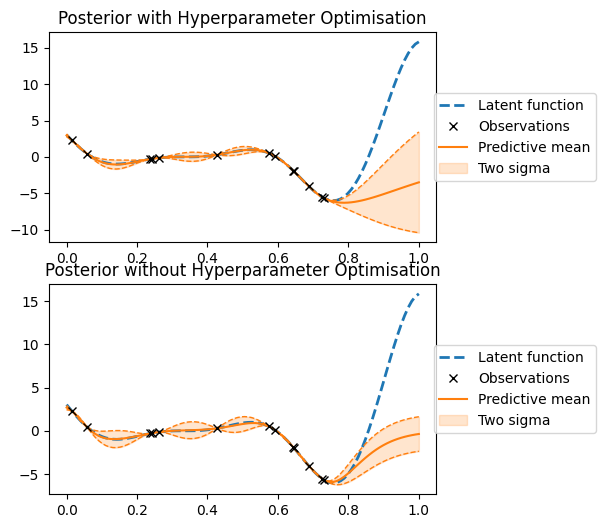

In [8]:
opt_latent_dist = opt_posterior.predict(test_x, train_data=D)
opt_predictive_dist = opt_posterior.likelihood(opt_latent_dist)

opt_predictive_mean = opt_predictive_dist.mean
opt_predictive_std = jnp.sqrt(opt_predictive_dist.variance)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))
ax1.plot(
    test_x, test_y, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax1.plot(training_x, training_y, "x", label="Observations", color="k", zorder=5)
plot_ribbon(ax1, test_x, opt_predictive_dist, color=cols[1])
ax1.set_title("Posterior with Hyperparameter Optimisation")
ax1.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

no_opt_latent_dist = no_opt_posterior.predict(test_x, train_data=D)
no_opt_predictive_dist = no_opt_posterior.likelihood(no_opt_latent_dist)

ax2.plot(
    test_x, test_y, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax2.plot(training_x, training_y, "x", label="Observations", color="k", zorder=5)
plot_ribbon(ax2, test_x, no_opt_predictive_dist, color=cols[1])
ax2.set_title("Posterior without Hyperparameter Optimisation")
ax2.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

We can see that optimising the hyperparameters by minimising the negative log marginal likelihood of the data results in a more faithful fit of the GP to the data. In particular, we can observe that the GP using optimised hyperparameters is more accurately able to reflect uncertainty in its predictions, as opposed to the GP using the default parameters, which is overconfident in its predictions.

The lengthscale, $\kappa$, and variance, $\sigma^2$, are shown below, both before and after optimisation:

In [9]:
no_opt_lengthscale = no_opt_posterior.prior.kernel.lengthscale
no_opt_variance = no_opt_posterior.prior.kernel.variance
opt_lengthscale = opt_posterior.prior.kernel.lengthscale
opt_variance = opt_posterior.prior.kernel.variance

print(f"Optimised Lengthscale: {opt_lengthscale} and Variance: {opt_variance}")
print(
    f"Non-Optimised Lengthscale: {no_opt_lengthscale} and Variance: {no_opt_variance}"
)

Optimised Lengthscale: PositiveReal( # 1 (8 B)
  value=Array(0.27423423, dtype=float64),
  tag='positive'
) and Variance: NonNegativeReal( # 1 (8 B)
  value=Array(25.38129642, dtype=float64),
  tag='non_negative'
)
Non-Optimised Lengthscale: PositiveReal( # 1 (8 B)
  value=Array(0.1, dtype=float64, weak_type=True),
  tag='positive'
) and Variance: NonNegativeReal( # 1 (8 B)
  value=Array(1., dtype=float64, weak_type=True),
  tag='non_negative'
)


## Expressing Other Priors with Different Kernels

Whilst the Matérn kernels are often used as a first choice of kernel, and they often perform well due to their smoothing properties often being well-aligned with the properties of the underlying function being modelled, sometimes more prior knowledge is known about the function being modelled. For instance, it may be known that the function being modelled is *periodic*. In this case, a suitable kernel choice would be the *periodic* kernel:

$$k(\mathbf{x}, \mathbf{x}') = \sigma^2 \exp \left( -\frac{1}{2} \sum_{i=1}^{D} \left(\frac{\sin (\pi (\mathbf{x}_i - \mathbf{x}_i')/p)}{\ell}\right)^2 \right)$$

with $D$ being the dimensionality of the inputs.

Below we show $10$ samples drawn from a GP prior using the periodic kernel:

Text(0.5, 1.0, 'Samples from the Periodic Kernel')

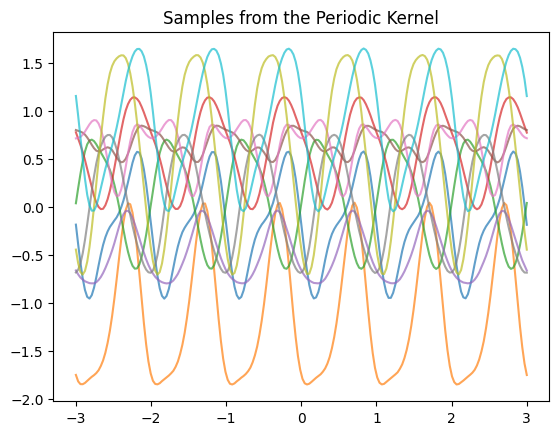

In [10]:
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.Periodic()
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
rv = prior(x)
y = rv.sample(key=key, sample_shape=(10,))

fig, ax = plt.subplots()
ax.plot(x, y.T, alpha=0.7)
ax.set_title("Samples from the Periodic Kernel")

In other scenarios, it may be known that the underlying function is *linear*, in which case the *linear* kernel would be a suitable choice:

$$k(\mathbf{x}, \mathbf{x}') = \sigma^2 \mathbf{x}^\top \mathbf{x}'$$

Unlike the kernels shown above, the linear kernel is *not* stationary, and so it is not invariant to translations in the input space.

Below we show $10$ samples drawn from a GP prior using the linear kernel:

Text(0.5, 1.0, 'Samples from the Linear Kernel')

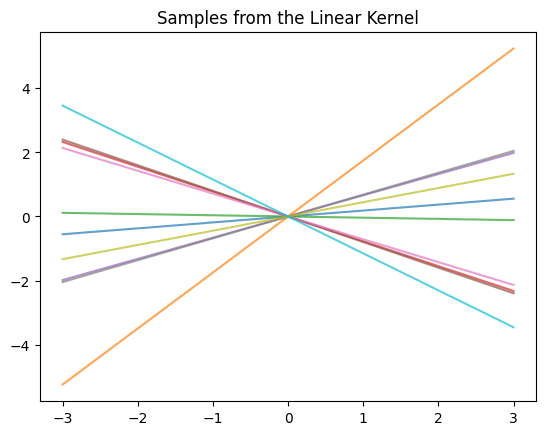

In [11]:
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.Linear()
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
rv = prior(x)
y = rv.sample(key=key, sample_shape=(10,))

fig, ax = plt.subplots()
ax.plot(x, y.T, alpha=0.7)
ax.set_title("Samples from the Linear Kernel")

## Composing Kernels

It is also mathematically valid to compose kernels through operations such as addition
and multiplication in order to produce more expressive kernels. For the mathematically
interested amongst you, this is valid as the resulting kernel functions still satisfy
the necessary conditions introduced at the [start of this
notebook](#what-are-the-necessary-conditions-for-a-function-to-be-a-valid-kernel).
Adding or multiplying kernel functions is equivalent to performing elementwise addition
or multiplication of the corresponding covariance matrices, and fortunately symmetric,
positive semi-definite kernels are closed under these operations. This means that
kernels produced by adding or multiplying other kernels will also be symmetric and
positive semi-definite, and so will also be valid kernels. GPJax provides the
functionality required to easily compose kernels via addition and multiplication, which
we'll demonstrate below.

First, we'll take a look at some samples drawn from a GP prior using a kernel which is
composed of the sum of a linear kernel and a periodic kernel:

Text(0.5, 1.0, 'Samples from a GP Prior with Kernel = Linear + Periodic')

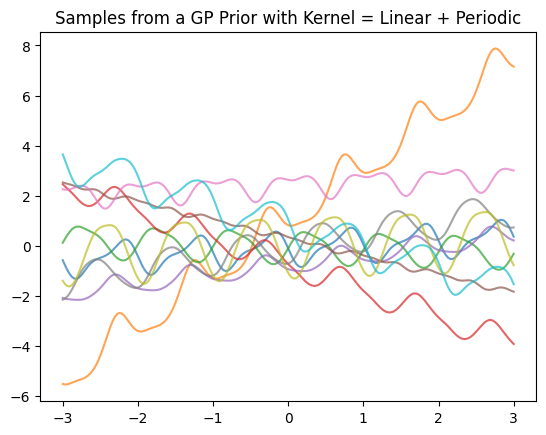

In [12]:
kernel_one = gpx.kernels.Linear()
kernel_two = gpx.kernels.Periodic()
sum_kernel = gpx.kernels.SumKernel(kernels=[kernel_one, kernel_two])
mean = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=mean, kernel=sum_kernel)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
rv = prior(x)
y = rv.sample(key=key, sample_shape=(10,))
fig, ax = plt.subplots()
ax.plot(x, y.T, alpha=0.7)
ax.set_title("Samples from a GP Prior with Kernel = Linear + Periodic")

We can see that the samples drawn behave as one would naturally expect through adding
the two kernels together. In particular, the samples are still periodic, as with the
periodic kernel, but their mean also linearly increases/decreases as they move away from
the origin, as seen with the linear kernel.

Below we take a look at some samples drawn from a GP prior using a kernel which is
composed of the same two kernels, but this time multiplied together:

Text(0.5, 1.0, 'Samples from a GP with Kernel = Linear x Periodic')

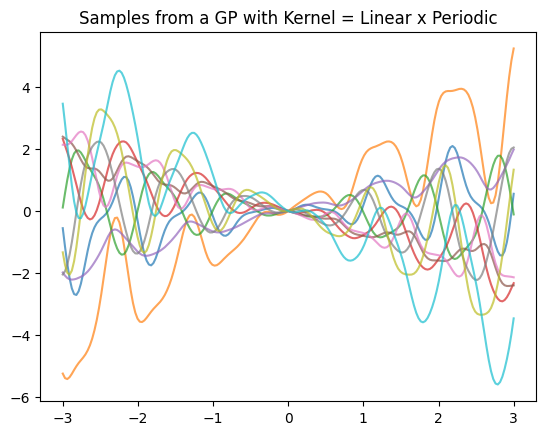

In [13]:
kernel_one = gpx.kernels.Linear()
kernel_two = gpx.kernels.Periodic()
sum_kernel = gpx.kernels.ProductKernel(kernels=[kernel_one, kernel_two])
mean = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=mean, kernel=sum_kernel)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
rv = prior(x)
y = rv.sample(key=key, sample_shape=(10,))
fig, ax = plt.subplots()
ax.plot(x, y.T, alpha=0.7)
ax.set_title("Samples from a GP with Kernel = Linear x Periodic")

Once again, the samples drawn behave as one would naturally expect through multiplying
the two kernels together. In particular, the samples are still periodic but their mean
linearly increases/decreases as they move away from the origin, and the amplitude of
the oscillations also linearly increases with increasing distance from the origin.

## Putting it All Together on a Real-World Dataset

### Mauna Loa CO2 Dataset

We'll put together some of the ideas we've discussed in this notebook by fitting a GP
to the [Mauna Loa CO2 dataset](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
This dataset measures atmospheric CO2 concentration at the Mauna Loa Observatory in
Hawaii, and is widely used in the GP literature. It contains monthly CO2 readings
starting in March 1958. Interestingly, there was an eruption at the Mauna Loa volcano in
November 2022, so readings from December 2022 have changed to a site roughly 21 miles
North of the Mauna Loa Observatory. We'll use the data from March 1958 to November 2022,
and see how our GP extrapolates to 8 years before and after the data in the training
set.

First we'll load the data and plot it:

Text(0, 0.5, 'CO2 Concentration (ppm)')

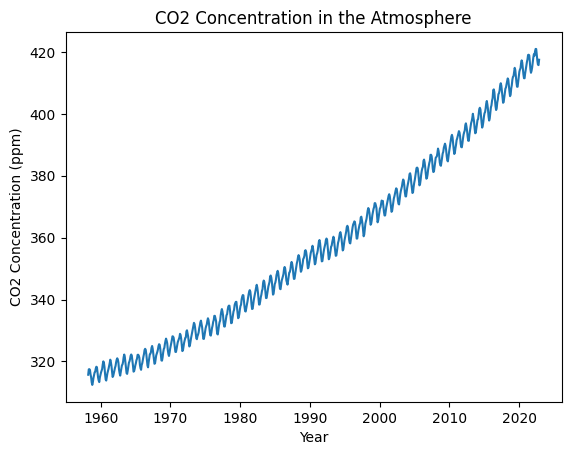

In [14]:
co2_data = pd.read_csv(
    "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", comment="#"
)
co2_data = co2_data.loc[co2_data["decimal date"] < 2022 + 11 / 12]
train_x = co2_data["decimal date"].values[:, None]
train_y = co2_data["average"].values[:, None]

fig, ax = plt.subplots()
ax.plot(train_x, train_y)
ax.set_title("CO2 Concentration in the Atmosphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 Concentration (ppm)")

Looking at the data, we can see that there is clearly a periodic trend, with a period of
roughly 1 year. We can also see that the data is increasing over time, which is
also expected. This looks roughly linear, although it may have a non-linear component.
This information will be useful when we come to choose our kernel.

First, we'll construct our GPJax dataset, and will standardise the outputs, to match our
assumption that the data has zero mean.

In [15]:
test_x = jnp.linspace(1950, 2030, 5000, dtype=jnp.float64).reshape(-1, 1)
y_scaler = StandardScaler().fit(train_y)
standardised_train_y = y_scaler.transform(train_y)

D = gpx.Dataset(X=train_x, y=standardised_train_y)

Having constructed our dataset, we'll now define our kernel. We'll use a kernel which is
composed of the sum of a linear kernel and a periodic kernel, as we saw in the previous
section that this kernel is able to capture both the periodic and linear trends in the
data. We'll also add an RBF kernel to the sum, which will allow us to capture any
non-linear trends in the data:

$$\text{Kernel = Linear + Periodic + RBF}$$



In [16]:
mean = gpx.mean_functions.Zero()
rbf_kernel = gpx.kernels.RBF(lengthscale=100.0)
periodic_kernel = gpx.kernels.Periodic()
linear_kernel = gpx.kernels.Linear(variance=0.001)
sum_kernel = gpx.kernels.SumKernel(kernels=[linear_kernel, periodic_kernel])
final_kernel = gpx.kernels.SumKernel(kernels=[rbf_kernel, sum_kernel])

prior = gpx.gps.Prior(mean_function=mean, kernel=final_kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood

With our model constructed, let's now fit it to the data, by minimising the negative log
marginal likelihood of the data:

In [17]:
def loss(posterior, data):
    return -gpx.objectives.conjugate_mll(posterior, data)


# Optimize all parameters. Alternative filtering strategies available:
# - trainable=gpx.PositiveReal: train only positive parameters
# - custom filters for specific parameter subsets
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=loss,
    train_data=D,
    optim=ox.adamw(learning_rate=1e-2),
    num_iters=500,
    key=key,
    trainable=Parameter,  # train all parameters (default)
)

  0%|          | 0/500 [00:00<?, ?it/s]

Now we can obtain the model's prediction over a period of time which includes the
training data, as well as 8 years before and after the training data:

In [18]:
latent_dist = opt_posterior.predict(test_x, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean.reshape(-1, 1)
predictive_std = jnp.sqrt(predictive_dist.variance).reshape(-1, 1)

Let's plot the model's predictions over this period of time:

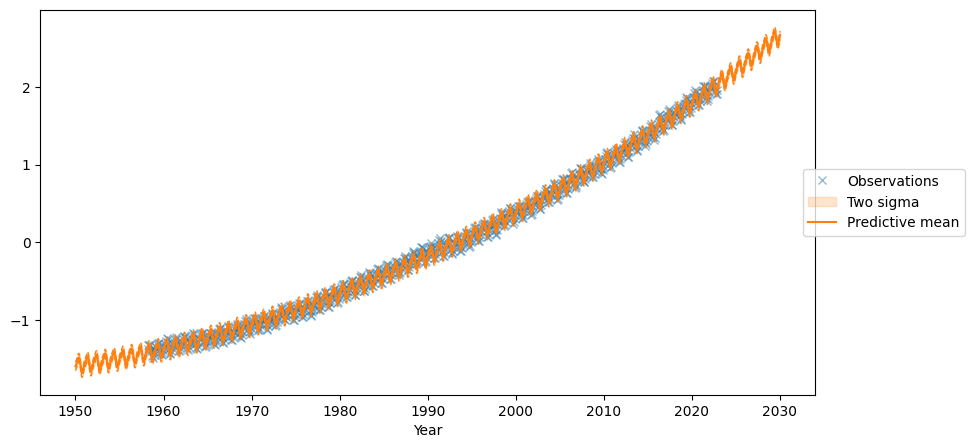

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    train_x, standardised_train_y, "x", label="Observations", color=cols[0], alpha=0.5
)
ax.fill_between(
    test_x.squeeze(),
    predictive_mean.squeeze() - 2 * predictive_std.squeeze(),
    predictive_mean.squeeze() + 2 * predictive_std.squeeze(),
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    test_x,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    test_x,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(test_x, predictive_mean, label="Predictive mean", color=cols[1])
ax.set_xlabel("Year")
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

We can see that the model seems to have captured the periodic trend in the data, as well
as the (roughly) linear trend. This enables our model to make reasonable seeming
predictions over the 8 years before and after the training data. Let's zoom in on the
period from 2010 onwards:


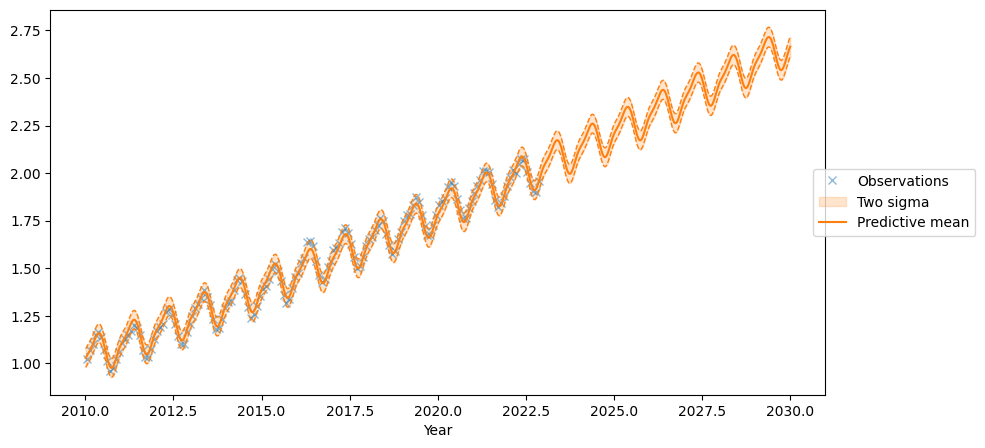

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    train_x[train_x >= 2010],
    standardised_train_y[train_x >= 2010],
    "x",
    label="Observations",
    color=cols[0],
    alpha=0.5,
)
ax.fill_between(
    test_x[test_x >= 2010].squeeze(),
    predictive_mean[test_x >= 2010] - 2 * predictive_std[test_x >= 2010],
    predictive_mean[test_x >= 2010] + 2 * predictive_std[test_x >= 2010],
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    test_x[test_x >= 2010],
    predictive_mean[test_x >= 2010] - 2 * predictive_std[test_x >= 2010],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    test_x[test_x >= 2010],
    predictive_mean[test_x >= 2010] + 2 * predictive_std[test_x >= 2010],
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    test_x[test_x >= 2010],
    predictive_mean[test_x >= 2010],
    label="Predictive mean",
    color=cols[1],
)
ax.set_xlabel("Year")
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

This certainly looks like a reasonable fit to the data, with sensible extrapolation
beyond the training data, which finishes in November 2022. Moreover, the learned
parameters of the kernel are interpretable. Let's take a look at the learned period of the periodic kernel:

In [21]:
print(
    "Periodic Kernel Period:"
    f" {[i for i in opt_posterior.prior.kernel.kernels if isinstance(i, gpx.kernels.Periodic)][0].period}"
)

Periodic Kernel Period: 1.0


This tells us that the periodic trend learned has a period of $\approx 1$. This makes
intuitive sense, as the unit of the input data is years, and we can see that the
periodic trend tends to repeat itself roughly every year!

## Defining Kernels on Non-Euclidean Spaces

In this notebook, we have focused solely on kernels whose domain resides in Euclidean space. However, what if one wished to work with data whose domain is non-Euclidean? For instance, one may wish to work with graph-structured data, or data which lies on a manifold, or even strings. Fortunately, kernels exist for a wide variety of domains. Whilst this is beyond the scope of this notebook, feel free to checkout out our [notebook on graph kernels](https://docs.jaxgaussianprocesses.com/_examples/graph_kernels/) for an introduction on how to define the Matérn kernel on graph-structured data, and there are a wide variety of resources online for learning about defining kernels in other domains. In terms of open-source libraries, the [Geometric Kernels](https://github.com/GPflow/GeometricKernels) library could be a good place to start if you're interested in looking at how these kernels may be implemented, with the additional benefit that it is compatible with GPJax.

## Further Reading

Congratulations on making it this far! We hope that this guide has given you a good introduction to kernels and how they can be used in GPJax. If you're interested in learning more about kernels, we recommend the following resources, which have also been used as inspiration for this guide:

- [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) - Chapter 4 provides a comprehensive overview of kernels, diving deep into some of the technical details and also providing some kernels defined on non-Euclidean spaces such as strings.
- David Duvenaud's [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) is a great resource for learning about kernels, and also provides some information about some of the pitfalls people commonly encounter when using the Matérn family of kernels. His PhD thesis, [Automatic Model Construction with Gaussian Processes](https://www.cs.toronto.edu/~duvenaud/thesis.pdf), also provides some in-depth recipes for how one may incorporate their prior knowledge when constructing kernels.
- Finally, please check out our [more advanced kernel guide](https://docs.jaxgaussianprocesses.com/_examples/constructing_new_kernels/), which details some more kernels available in GPJax as well as how one may combine kernels together to form more complex kernels.

## System Configuration

In [22]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Christie'

Author: Thomas Christie

Last updated: Wed Dec 03 2025

Python implementation: CPython
Python version       : 3.13.0
IPython version      : 9.7.0

pandas    : 2.3.3
jax       : 0.8.1
gpjax     : 0.13.4
sklearn   : 1.7.2
jaxtyping : 0.3.3
matplotlib: 3.10.7
optax     : 0.2.6

Watermark: 2.5.0

